# Experiment 2: Parameter Estimation with Noisy Data

This experiment is also a recreation of the Mpox synthetic case found in the paper. Now random noise is added to the data to test the model's abitilty to recover the ideal model.

## Import Statements

In [1]:
from caputo import caputo_euler
from EpiPINN import EpiPINN, train_stage1, train_stage2
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
import os

## Generate Data

Data is generated by solving the following fractional-order ODE using the Caputo-Euler method.

$
\begin{align*}
_{0}^{\mathrm{C}}\mathrm{D}_{t}^{\alpha}[s] &= -\beta \frac{si}{1 - d} \\
_{0}^{\mathrm{C}}\mathrm{D}_{t}^{\alpha}[e] &= \beta \frac{si}{1 - d} - \sigma e \\
_{0}^{\mathrm{C}}\mathrm{D}_{t}^{\alpha}[i] &= \sigma e - (\gamma + \mu) i \\
_{0}^{\mathrm{C}}\mathrm{D}_{t}^{\alpha}[r] &= \gamma i \\
_{0}^{\mathrm{C}}\mathrm{D}_{t}^{\alpha}[d] &= \mu i
\end{align*}
$

Further, true parameters are selected randomly from a specified range, and noise is superimposed upon the exact FDE solution.

In [2]:
def generate_true_data():
    # ranges determined by table 1 and 3
    alpha_min, alpha_max = 0.9, 1.0
    beta_min, beta_max = 0.1, 0.4
    sigma_min, sigma_max = 0.077, 0.3
    gamma_min, gamma_max = 0.036, 0.1
    mu_min, mu_max = 0.001, 0.03

    alpha_true = random.uniform(alpha_min, alpha_max)
    beta_true = random.uniform(beta_min, beta_max)
    sigma_true = random.uniform(sigma_min, sigma_max)
    gamma_true = random.uniform(gamma_min, gamma_max)
    mu_true = random.uniform(mu_min, mu_max)
    return alpha_true, beta_true, sigma_true, gamma_true, mu_true

In [3]:
# Additional noise-adding function
def add_noise(ys, noise_level):
    """Add Gaussian noise to a signal.

    Args:
        ys (numpy.ndarray): The clean signal to which noise will be added.
        noise_level (float): Standard deviation of the Gaussian noise to add,
                             relative to the standard deviation of the input signal.

    Returns:
        numpy.ndarray: The noisy signal.
    """
    if noise_level <= 0.0:
        return ys
    # Calc magnitude based on standard deviation of the signal
    std_dev_ys = np.std(ys, axis=0 if ys.ndim > 1 else None)
    noise_scale = noise_level * np.where(std_dev_ys < 1e-10, 1.0, std_dev_ys)
    noise = np.random.normal(loc=0.0, scale=noise_scale, size=ys.shape)
    ys_noisy = ys + noise

    return ys_noisy

In [4]:
# Data generation
alpha_true, beta_true, sigma_true, gamma_true, mu_true = generate_true_data()
print(f'True parameters: alpha={alpha_true:.4f}, beta={beta_true:.4f}, sigma={sigma_true:.4f}, gamma={gamma_true:.4f}, mu={mu_true:.4f}')

y0 = np.array([0.99, 0.01, 0, 0, 0]) # Initial state: 1% exposed
t0 = 0
tf = 500 # 500 days
num_step = 200 # Good ground truth from tests

f = lambda t, y: np.array([
    - beta_true * (y[0] * y[2]) / (1 - y[4]),
    beta_true * (y[0] * y[2]) / (1 - y[4]) - sigma_true * y[1],
    sigma_true * y[1] - (gamma_true + mu_true) * y[2],
    gamma_true * y[2],
    mu_true * y[2]
])

ts, ys = caputo_euler(f, alpha_true, (t0, tf), num_step, y0)

# Add noise to data
noise_level = 0.1 # 10% noise
ys_noisy = add_noise(ys, noise_level)
ts_train = torch.tensor(ts.reshape(-1, 1), dtype=torch.float32)
ys_train = torch.tensor(ys_noisy, dtype=torch.float32)

True parameters: alpha=0.9558, beta=0.3799, sigma=0.1283, gamma=0.0422, mu=0.0150


## Build and Train Model

In [5]:
# Define model
min_alpha_guess = 0.9 # Mimimum searched derivative fraction
alpha_guess = 0.96 # Derivative fraction used for model
scaled_alpha_guess = (alpha_guess - min_alpha_guess) / (1.0 - min_alpha_guess) # Rescaling for search set to match range of sigmoid (0, 1)
z_alpha_guess = np.log(scaled_alpha_guess / (1 - scaled_alpha_guess)) # Inverse sigmoid
beta_guess = 0.26 # Infection rate used for model
sigma_guess = 0.14 # Incubation rate used for model
gamma_guess = 0.053 # Recovery rate used for model
mu_guess = 0.006 # Death rate used for model
hidden_size = 64 # Number of neurons per layer
depth = 3 # Number of layers
ts_colloc = torch.from_numpy(np.linspace(t0, tf, 400)).float().unsqueeze(1)
initial_params = {
    "z_alpha": z_alpha_guess,
    "min_alpha": min_alpha_guess,
    "beta": beta_guess,
    "sigma": sigma_guess,
    "gamma": gamma_guess,
    "mu": mu_guess,
    "dt": (tf - t0) / num_step
}
ic = torch.tensor(y0, dtype=torch.float32).unsqueeze(0)

model_noisy = EpiPINN(hidden_size, depth, initial_params)

### Stage 1 Training

In [6]:
# Start timing
start1 = time.time()

# Stage 1: weights only, without considering physics in updates
losses1, losses1_data, losses1_ic, losses1_phys = train_stage1(
    model_noisy,
    ts_train,
    ys_train,
    ts_colloc,
    ic,
    optim.Adam(model_noisy.parameters(), lr=1e-3, weight_decay=1e-5),
    epochs=3000,
    patience=500,
    pr=100
)

# Stop timing
stop1 = time.time()
print(f'Complete in {stop1 - start1} seconds')

# Confirm epidemiological parameters are unchanged
print(f'alpha = {model_noisy.alpha().item()}')
print(f'beta = {model_noisy.beta().item()}')
print(f'gamma = {model_noisy.gamma().item()}')
print(f'sigma = {model_noisy.sigma().item()}')
print(f'mu = {model_noisy.mu().item()}')

Epoch [100/3000], Loss: 0.001571, Patience: 0
Epoch [200/3000], Loss: 0.000878, Patience: 0
Epoch [300/3000], Loss: 0.000762, Patience: 0
Epoch [400/3000], Loss: 0.000735, Patience: 0
Epoch [500/3000], Loss: 0.000731, Patience: 0
Epoch [600/3000], Loss: 0.000728, Patience: 0
Epoch [700/3000], Loss: 0.000727, Patience: 0
Epoch [800/3000], Loss: 0.000725, Patience: 0
Epoch [900/3000], Loss: 0.000724, Patience: 0
Epoch [1000/3000], Loss: 0.000723, Patience: 2
Epoch [1100/3000], Loss: 0.000721, Patience: 0
Epoch [1200/3000], Loss: 0.000720, Patience: 0
Epoch [1300/3000], Loss: 0.000718, Patience: 0
Epoch [1400/3000], Loss: 0.000720, Patience: 4
Epoch [1500/3000], Loss: 0.000716, Patience: 0
Epoch [1600/3000], Loss: 0.000715, Patience: 3
Epoch [1700/3000], Loss: 0.000713, Patience: 0
Epoch [1800/3000], Loss: 0.000712, Patience: 1
Epoch [1900/3000], Loss: 0.000713, Patience: 9
Epoch [2000/3000], Loss: 0.000710, Patience: 0
Epoch [2100/3000], Loss: 0.000709, Patience: 2
Epoch [2200/3000], Los

### Stage 1 Training Results

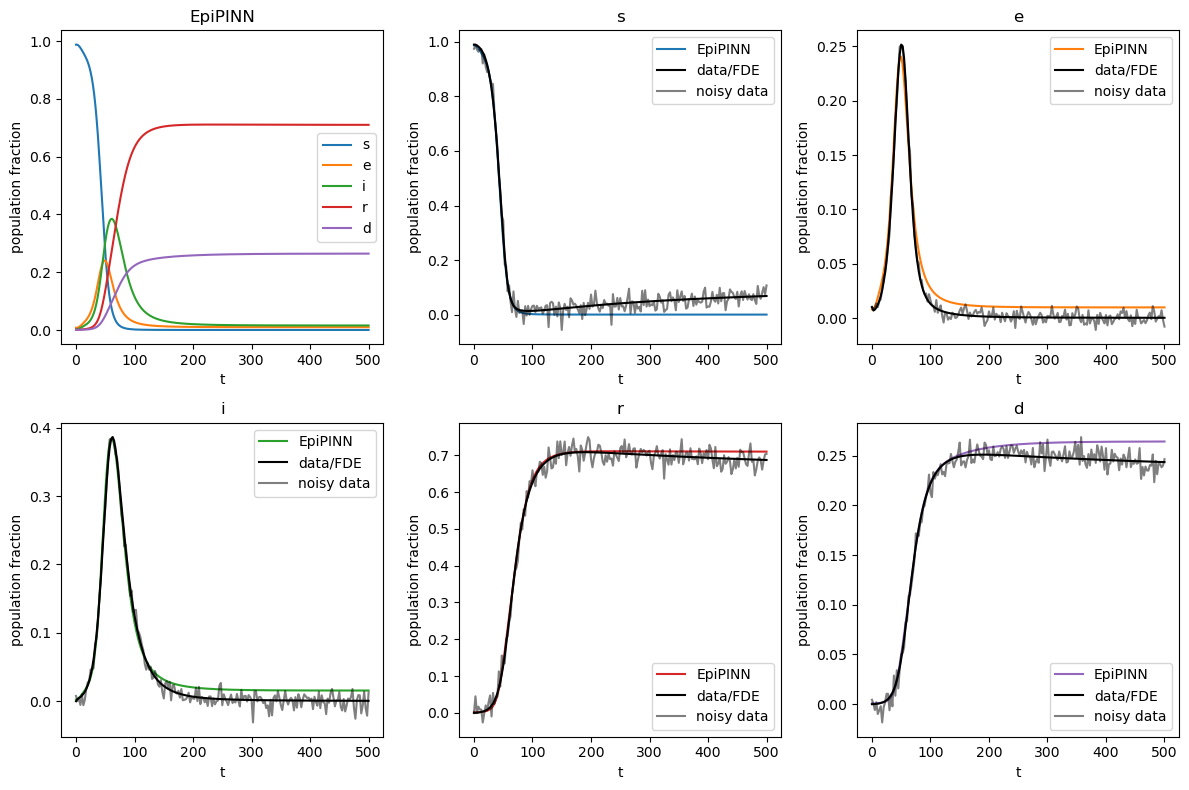

In [7]:
# Compound plot of model results, and comparison against data
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
labels = ['EpiPINN', 's', 'e', 'i', 'r', 'd']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ts_val = torch.from_numpy(np.linspace(t0, tf, 1000)).float().unsqueeze(1)
model_noisy.eval()
with torch.no_grad():
    ys_val = model_noisy(ts_val)

# Full system
for i in range(5):
    axs[0, 0].plot(ts_val, ys_val[:, i], label=labels[i + 1])

# Individial plots
for i in range(5):
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts_val, ys_val[:, i], label='EpiPINN', color=colors[i])
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts, ys[:, i], label='data/FDE', color='k')
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts, ys_noisy[:, i], label='noisy data', color='k', alpha=0.5)

for i in range(6):
    axs[i // 3, i % 3].set_title(labels[i])
    axs[i // 3, i % 3].set_xlabel('t')
    axs[i // 3, i % 3].set_ylabel('population fraction')
    axs[i // 3, i % 3].legend()

fig.tight_layout()
fig.savefig('doc/images/experiment2_stage1.png')

### Stage 2 Training

In [8]:
# Start timing
start2 = time.time()

# Stage 2: weights and epidemiological parameters, considering full loss
losses2, losses2_data, losses2_ic, losses2_phys, alphas, betas, sigmas, gammas, mus = train_stage2(
    model_noisy,
    ts_train,
    ys_train,
    ts_colloc,
    ic,
    optim.Adam(model_noisy.parameters(), lr=1e-3, weight_decay=1e-5),
    epochs=4000,
    patience=500,
    weight_ic_phys=1e6,
    pr=100
)

# Time stage 2 and cumulative
stop2 = time.time()
print(f'Complete in {stop2 - start2} seconds')

# Confirm epidemiological parameters are unchanged
print(f'alpha = {model_noisy.alpha().item()}')
print(f'beta = {model_noisy.beta().item()}')
print(f'gamma = {model_noisy.gamma().item()}')
print(f'sigma = {model_noisy.sigma().item()}')
print(f'mu = {model_noisy.mu().item()}')

Epoch [100/4000], Loss: 0.269678, Patience: 0
Epoch [200/4000], Loss: 0.138280, Patience: 0
Epoch [300/4000], Loss: 0.085046, Patience: 0
Epoch [400/4000], Loss: 0.066634, Patience: 0
Epoch [500/4000], Loss: 0.058093, Patience: 2
Epoch [600/4000], Loss: 0.050971, Patience: 4
Epoch [700/4000], Loss: 0.045769, Patience: 0
Epoch [800/4000], Loss: 0.042078, Patience: 3
Epoch [900/4000], Loss: 0.038795, Patience: 7
Epoch [1000/4000], Loss: 0.036634, Patience: 10
Epoch [1100/4000], Loss: 0.037125, Patience: 20
Epoch [1200/4000], Loss: 0.029724, Patience: 0
Epoch [1300/4000], Loss: 0.043489, Patience: 30
Epoch [1400/4000], Loss: 0.025791, Patience: 0
Epoch [1500/4000], Loss: 0.024393, Patience: 0
Epoch [1600/4000], Loss: 0.025511, Patience: 3
Epoch [1700/4000], Loss: 0.021820, Patience: 4
Epoch [1800/4000], Loss: 0.022077, Patience: 9
Epoch [1900/4000], Loss: 0.019468, Patience: 0
Epoch [2000/4000], Loss: 0.018539, Patience: 6
Epoch [2100/4000], Loss: 0.042466, Patience: 24
Epoch [2200/4000],

In [9]:
# Save model
torch.save(model_noisy.state_dict(), 'experiment2.pth')

### Stage 2 Training Results

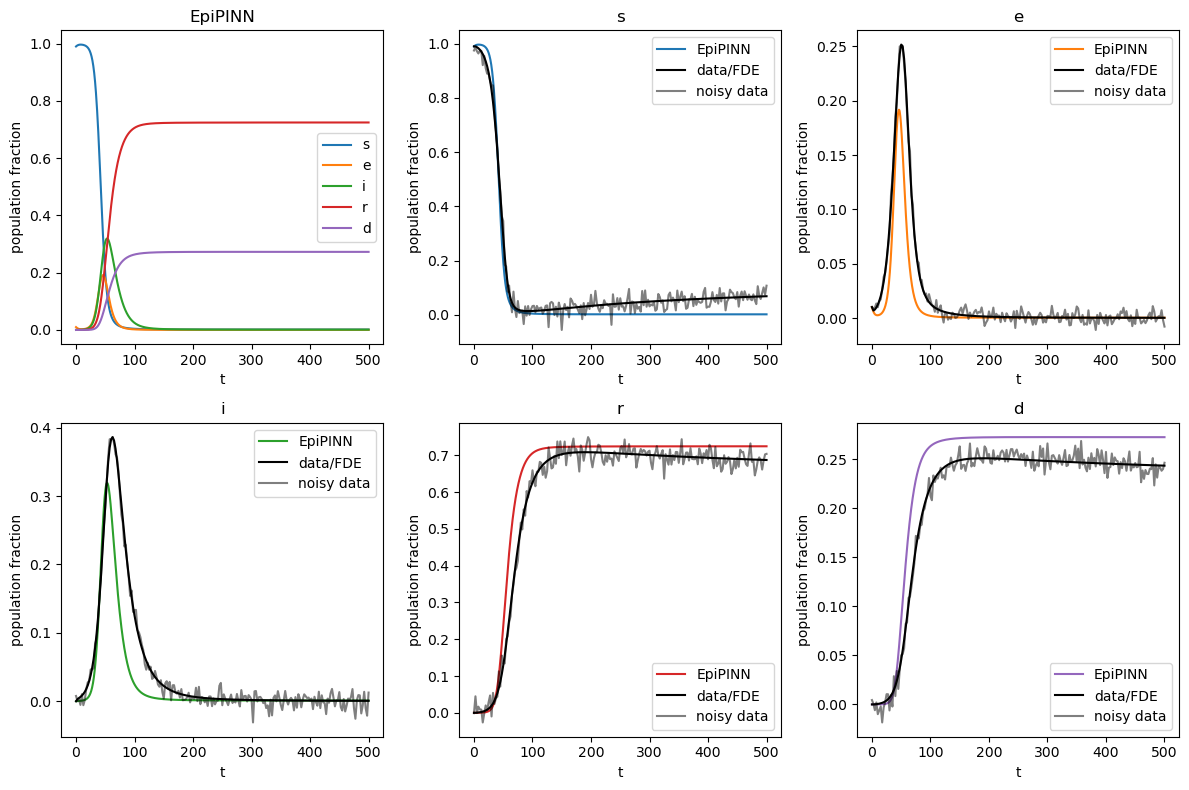

In [10]:
# Compound plot of model results, and comparison against data
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
labels = ['EpiPINN', 's', 'e', 'i', 'r', 'd']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ts_val = torch.from_numpy(np.linspace(t0, tf, 1000)).float().unsqueeze(1)
model_noisy.eval()
with torch.no_grad():
    ys_val = model_noisy(ts_val)

# Full system
for i in range(5):
    axs[0, 0].plot(ts_val, ys_val[:, i], label=labels[i + 1])

# Individial plots
for i in range(5):
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts_val, ys_val[:, i], label='EpiPINN', color=colors[i])
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts, ys[:, i], label='data/FDE', color='k')
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts, ys_noisy[:, i], label='noisy data', color='k', alpha=0.5)

for i in range(6):
    axs[i // 3, i % 3].set_title(labels[i])
    axs[i // 3, i % 3].set_xlabel('t')
    axs[i // 3, i % 3].set_ylabel('population fraction')
    axs[i // 3, i % 3].legend()

fig.tight_layout()
fig.savefig('doc/images/experiment2_stage2.png')

## Loss and Parameter Estimation Analysis

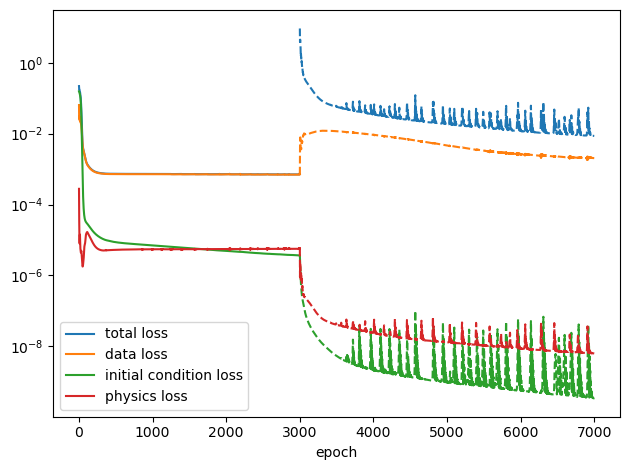

In [11]:
# Loss plot
l1 = len(losses1)
l2 = len(losses2)
epochs1 = range(l1)
epochs2 = range(l1, l1 + l2)
fig, ax = plt.subplots()
ax.semilogy(epochs1, losses1, label='total loss', color=colors[0])
ax.semilogy(epochs1, losses1_data, label='data loss', color=colors[1])
ax.semilogy(epochs1, losses1_ic, label='initial condition loss', color=colors[2])
ax.semilogy(epochs1, losses1_phys, label='physics loss', color=colors[3])
ax.semilogy(epochs2, losses2, color=colors[0], ls='--')
ax.semilogy(epochs2, losses2_data, color=colors[1], ls='--')
ax.semilogy(epochs2, losses2_ic, color=colors[2], ls='--')
ax.semilogy(epochs2, losses2_phys, color=colors[3], ls='--')
ax.set_xlabel('epoch')
ax.legend()

fig.tight_layout()
fig.savefig('doc/images/experiment2_losses.png')

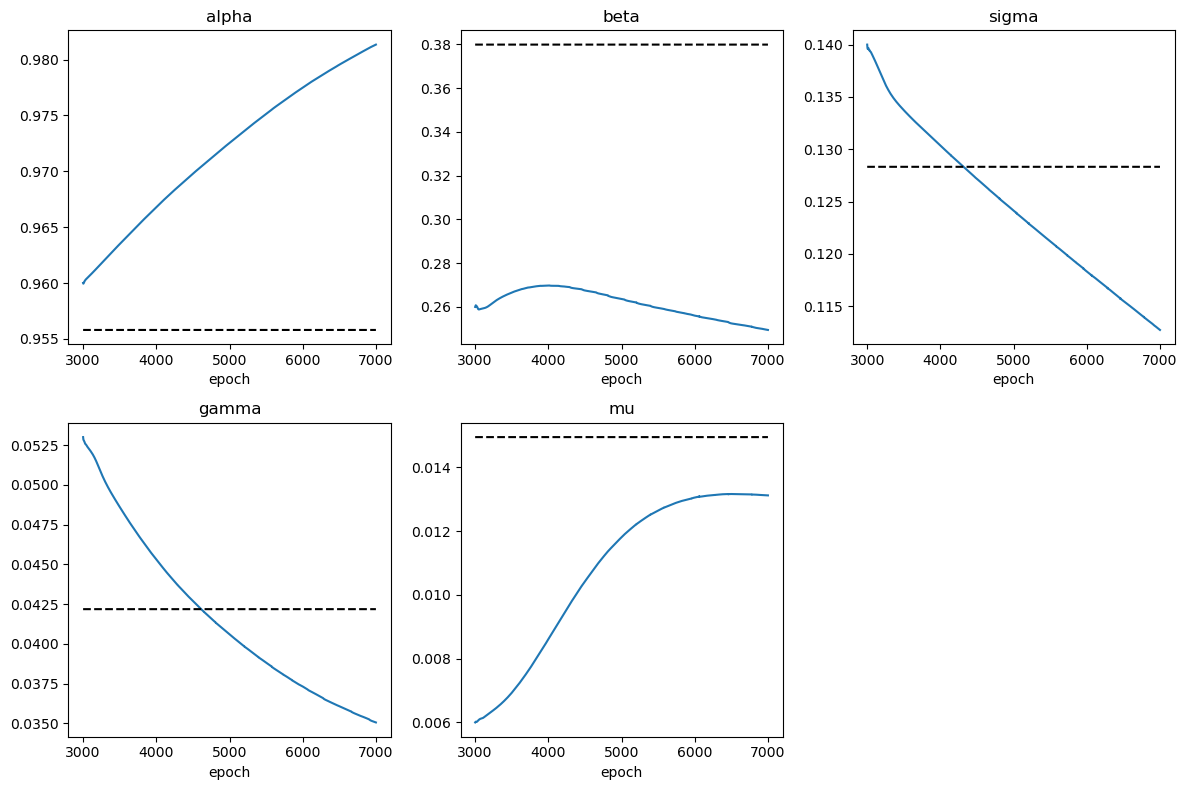

In [12]:
# Parameter convergence
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

axs[0, 0].plot(epochs2, alphas)
axs[0, 0].plot(epochs2, alpha_true * np.ones(l2), color='k', ls='--')
axs[0, 0].set_title('alpha')
axs[0, 0].set_xlabel('epoch')

axs[0, 1].plot(epochs2, betas)
axs[0, 1].plot(epochs2, beta_true * np.ones(l2), color='k', ls='--')
axs[0, 1].set_title('beta')
axs[0, 1].set_xlabel('epoch')

axs[0, 2].plot(epochs2, sigmas)
axs[0, 2].plot(epochs2, sigma_true * np.ones(l2), color='k', ls='--')
axs[0, 2].set_title('sigma')
axs[0, 2].set_xlabel('epoch')

axs[1, 0].plot(epochs2, gammas)
axs[1, 0].plot(epochs2, gamma_true * np.ones(l2), color='k', ls='--')
axs[1, 0].set_title('gamma')
axs[1, 0].set_xlabel('epoch')

axs[1, 1].plot(epochs2, mus)
axs[1, 1].plot(epochs2, mu_true * np.ones(l2), color='k', ls='--')
axs[1, 1].set_title('mu')
axs[1, 1].set_xlabel('epoch')

# Hide the unused 6th subplot
axs[1, 2].axis('off')

fig.tight_layout()
fig.savefig('doc/images/experiment2_parameters.png')